# SYSID - Trabalho (ML - SIMO.PL)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#MO
from sklearn.multioutput import MultiOutputRegressor

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor, SYSIDRandomizedSearchCV

# Modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score



#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/data/volve_compiled.pkl


In [3]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


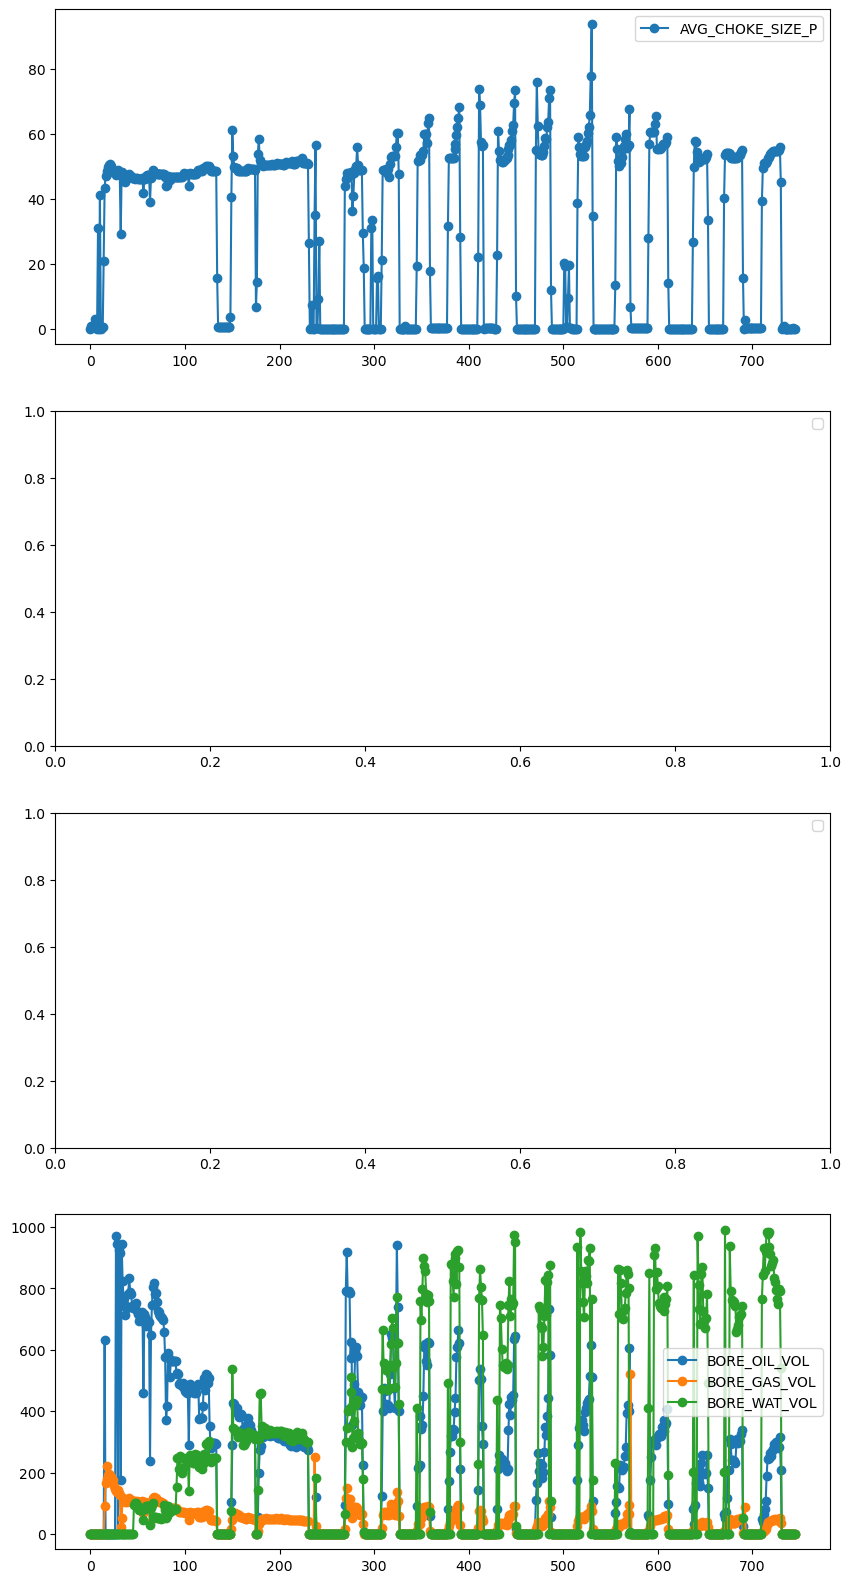

In [4]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        #'AVG_DOWNHOLE_PRESSURE',
        #'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        #'AVG_WHT_P',
        #'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        'BORE_OIL_VOL',
        #'BORE_LIQ_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [5]:
data_case = data_case.loc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [6]:
p_train = 0.8 #80% treino

### 1.2 - Separando os conjuntos

In [7]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

In [8]:
print(
    X1_tr.shape,
    X1_te.shape
)

(574, 1) (144, 1)


In [9]:
print(
    y_tr.shape,
    y_te.shape
)

(574, 3) (144, 3)


In [10]:
y_scale = MinMaxScaler()
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

In [11]:
models = [
    ('LinReg',  LinearRegression(copy_X=True)),
    ('SVM',     SVR(max_iter=-1)),
    ('KNN',     KNeighborsRegressor()),
    ('DT',      DecisionTreeRegressor(random_state=rs)),
    ('RF',      RandomForestRegressor(random_state=rs)),
]

n_models = len(models)

In [12]:
parameters = [
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'positive'            : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
]

In [13]:
#t_tr = np.arange(570)
#tmax = np.max(t_tr)
#nfolds = 3
#rkf = [
#    ((t_tr <= tmax/3),(tmax/3 < t_tr)&(t_tr <= 2*tmax/3),),
#    ((tmax/3 < t_tr)&(t_tr <= 2*tmax/3),(2*tmax/3 < t_tr),),
#]
kfolds = 5
niters = 50
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

In [14]:
results = {
    'MODEL':[],
    'R2 TRAIN':[],
    'R2 TEST':[],
    'MODEL OBJ':[],
    #'PARS':[]
}

Iniciando avaliação do modelo: LinReg


/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



    Tempo de execução: 0:00:01.837716
    Minimum  error: -0.518513378382418
    Maximum  error: 0.9454876802612685
    R2 score (Train): 0.32846110836595843 0.26387889672851605 0.10711440974206399
    R2 score (Test): -0.6187864798005116 -0.3427267600264887 0.1460945040786138

Iniciando avaliação do modelo: SVM


KeyboardInterrupt: 

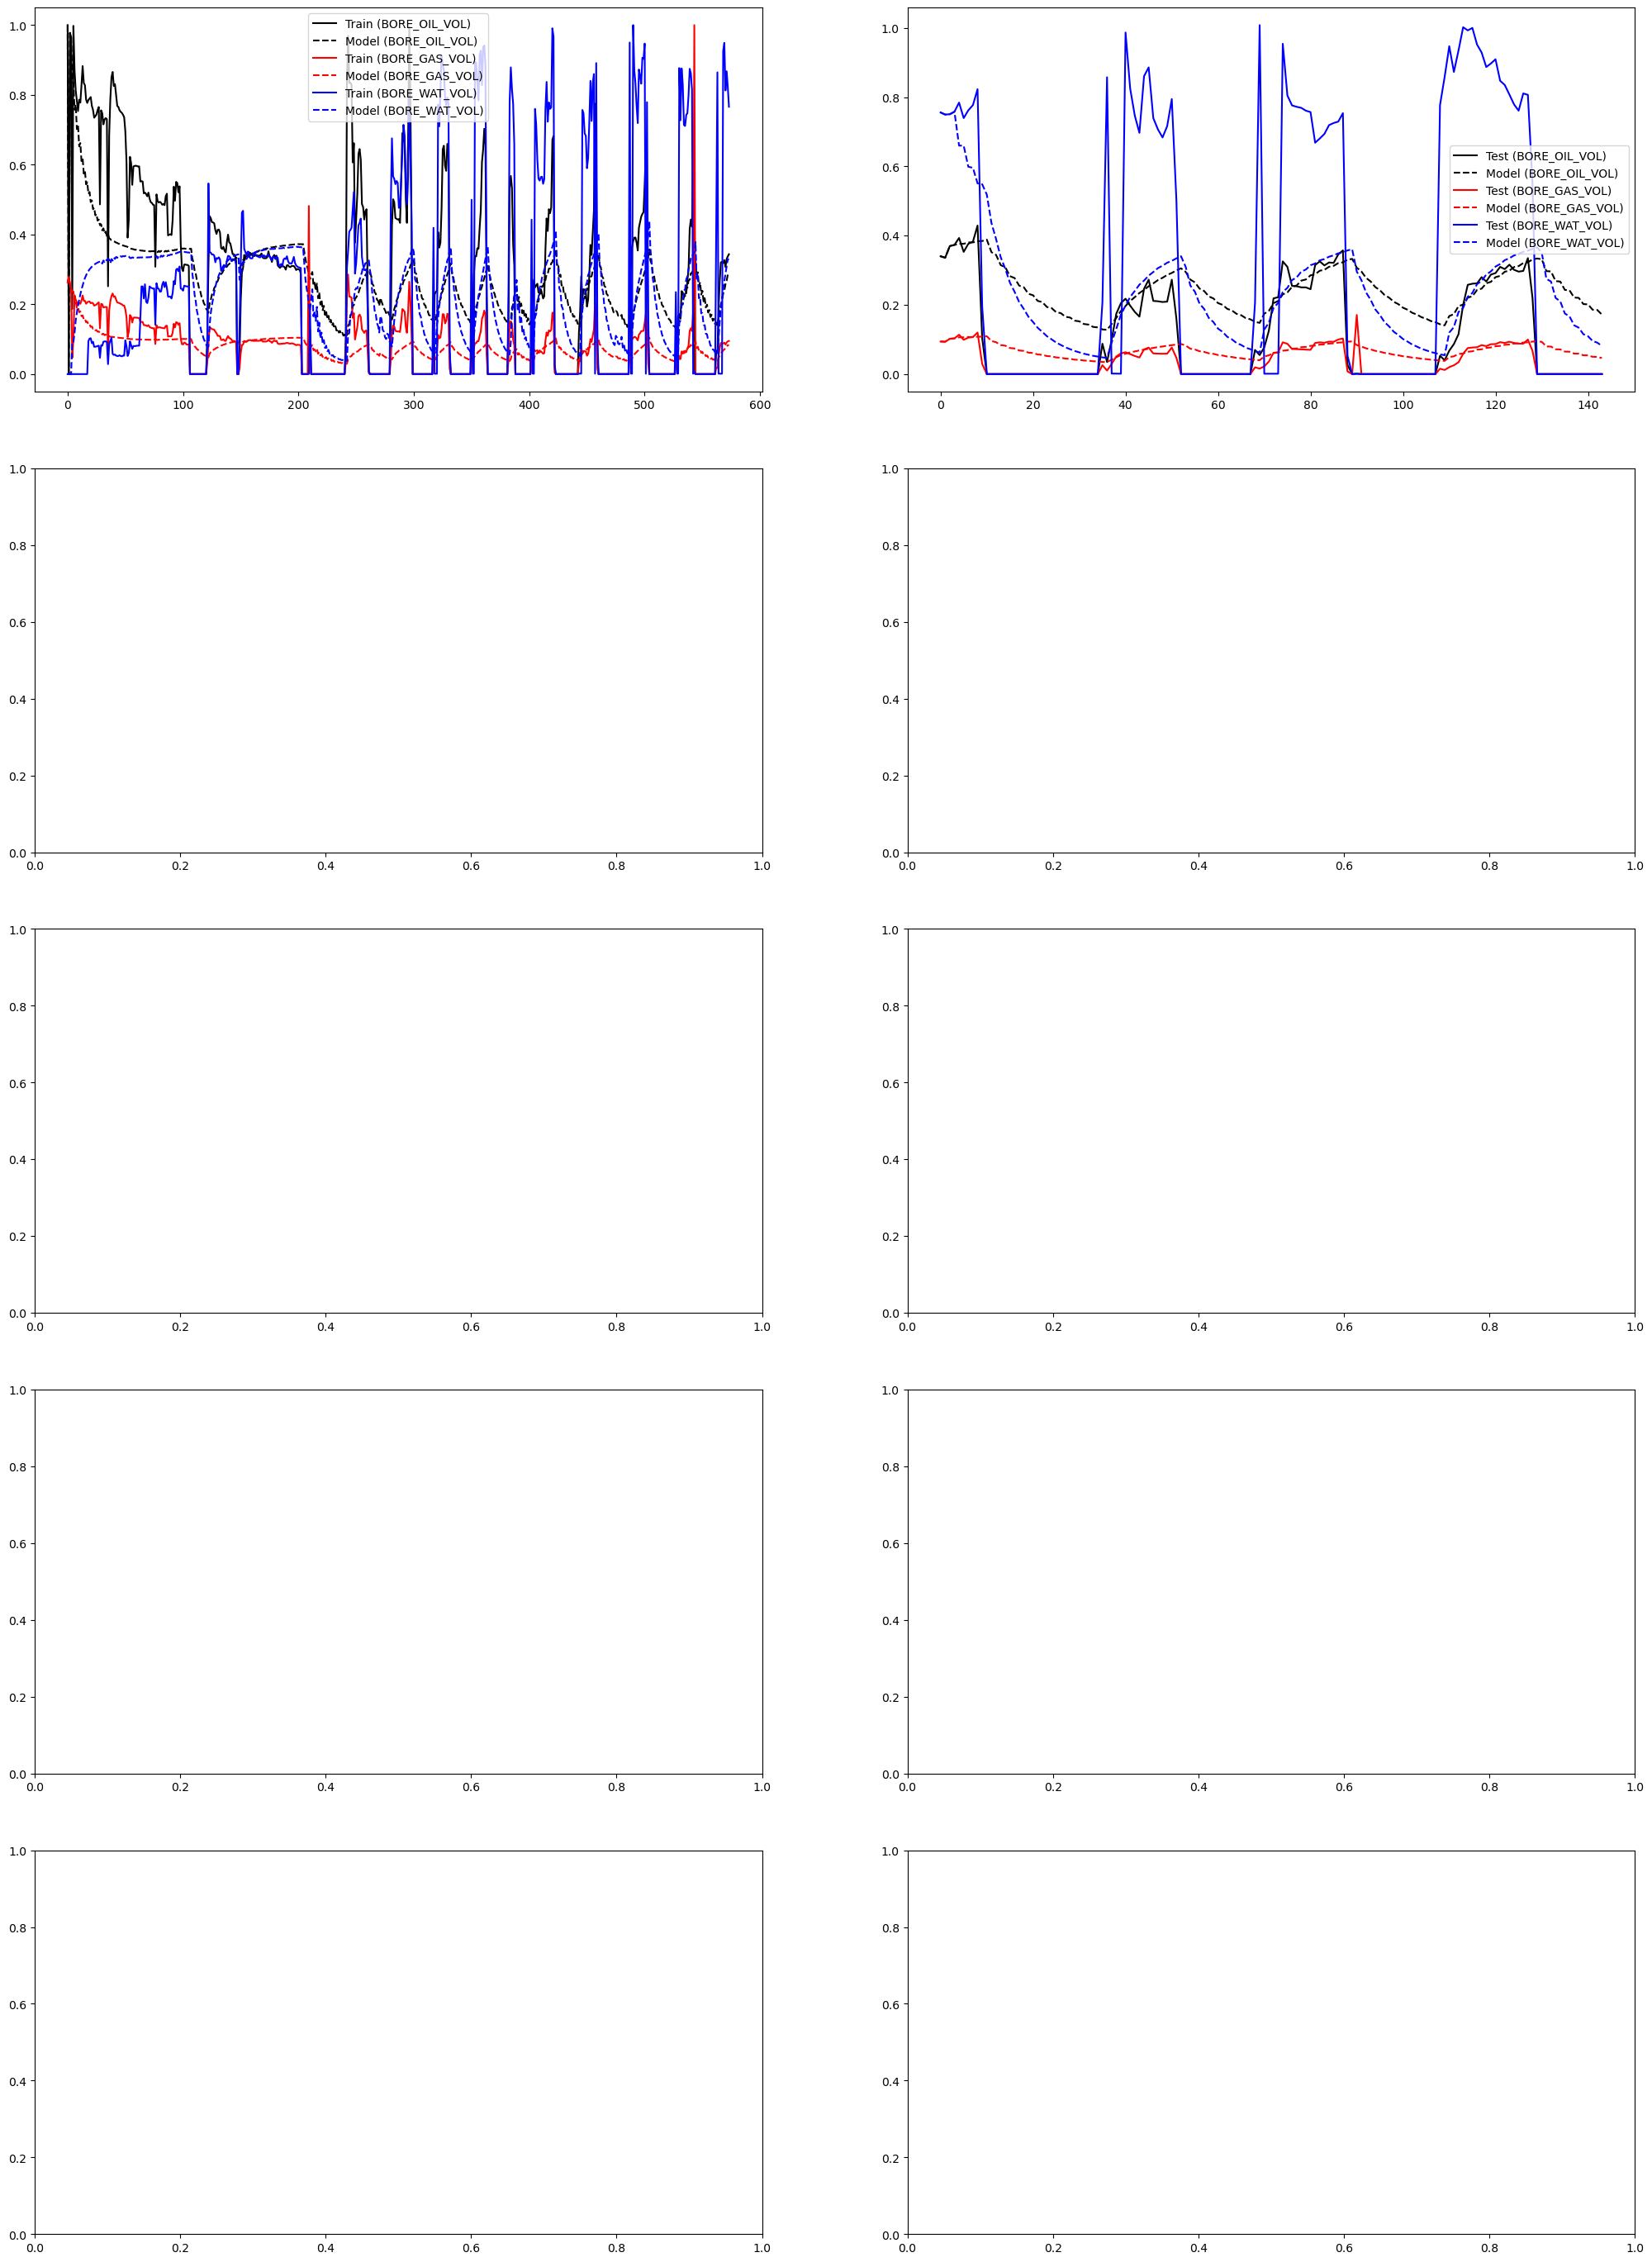

In [15]:
n_iter = 100 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    model_bin = model[1]
    print('Iniciando avaliação do modelo: {}'.format(model_name))

    rdmsearch = RandomizedSearchCV(model_bin, verbose=0, scoring='r2', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)

    MOreg = MultiOutputRegressor(rdmsearch)
    
    sidmodel = SYSIDRegressor(
        nX=4, ny=4,
        estimator=MOreg, 
        preprocessor=MinMaxScaler(),
        expansor=PolynomialFeatures(degree=1)
        )
    
    t0 = datetime.now()
    
    #
        
    sidmodel.fit(X1_tr, y_tr)
    
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    error = (y_te - sidmodel.predict(X1_te, y=y_te))
    print('    Minimum  error:', error.min())
    print('    Maximum  error:', error.max())
    r2_tr = [r2_score(y_tr[:,i], sidmodel.predict(X1_tr, y=y_tr)[:,i]) for i in range(len(filt_vars_OUT))]
    r2_te = [r2_score(y_te[:,i], sidmodel.predict(X1_te, y=y_te)[:,i]) for i in range(len(filt_vars_OUT))]
    print('    R2 score (Train):', *r2_tr)
    print('    R2 score (Test):', *r2_te)
    

    # PLOTANDO
    color = ['k', 'r', 'b']
    ind = [0, 1, 2]
    for i, c, var in zip(ind, color, filt_vars_OUT):

        hist = ax[0].plot(y_tr[:,i], c, label=f'Train ({var})')
        hist = ax[0].plot(sidmodel.predict(X1_tr, y=y_tr)[:,i], c+'--', label=f'Model ({var})')
        hist = ax[1].plot(y_te[:,i], c, label=f'Test ({var})')
        hist = ax[1].plot(sidmodel.predict(X1_te, y=y_te)[:,i], c+'--', label=f'Model ({var})')
    
    ax[0].legend()
    ax[1].legend()
    print()
    for i in ind:
        results['MODEL'].append(f'{model_name}_{i}')
        results['R2 TRAIN'].append(r2_tr[i])
        results['R2 TEST'].append(r2_te[i])
        results['MODEL OBJ'].append(sidmodel)
    

In [ ]:
pd.DataFrame(results)

,MODEL,R2 TRAIN,R2 TEST,MODEL OBJ
0,LinReg_0,0.329774,-1.021405,SYSIDRegressor(estimator=MultiOutputRegressor(...
1,LinReg_1,0.263843,-0.633296,SYSIDRegressor(estimator=MultiOutputRegressor(...
2,LinReg_2,0.469030,0.530622,SYSIDRegressor(estimator=MultiOutputRegressor(...
3,SVM_0,0.675256,0.450574,SYSIDRegressor(estimator=MultiOutputRegressor(...
4,SVM_1,0.112708,-2.304080,SYSIDRegressor(estimator=MultiOutputRegressor(...
5,SVM_2,0.517107,0.487329,SYSIDRegressor(estimator=MultiOutputRegressor(...
6,KNN_0,0.221593,-1.769321,SYSIDRegressor(estimator=MultiOutputRegressor(...
7,KNN_1,0.222771,-1.893245,SYSIDRegressor(estimator=MultiOutputRegressor(...
8,KNN_2,-0.139640,-0.476331,SYSIDRegressor(estimator=MultiOutputRegressor(...
9,DT_0,0.093173,-3.223795,SYSIDRegressor(estimator=MultiOutputRegressor(...
